<a href="https://colab.research.google.com/github/RosasGabriel/UFPB_ai_exam02/blob/main/AI_exam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [60]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt

#Imports para préprocessamento
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder

#Imports para método de Árvore de Decisão
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

dog_db = pd.read_csv('dog_database.csv')

# Prints para checagem de leitura do arquivo
# print(dog_db)
# print(dog_db.head())
# print(dog_db.shape)

ignored_columns = ['description', 'temperament', 'grooming_frequency_category', 'shedding_category', 'energy_level_category', 'trainability_category', 'demeanor_category']

dog_db = dog_db.drop(ignored_columns, axis=1) 
# print(dog_db)
print(dog_db.head())
print(dog_db.shape)

         Unnamed: 0 popularity  min_height  max_height  min_weight  \
0     Affenpinscher        148       22.86       29.21    3.175147   
1      Afghan Hound        113       63.50       68.58   22.679619   
2  Airedale Terrier         60       58.42       58.42   22.679619   
3             Akita         47       60.96       71.12   31.751466   
4  Alaskan Malamute         58       58.42       63.50   34.019428   

   max_weight  min_expectancy  max_expectancy          group  \
0    4.535924            12.0            15.0      Toy Group   
1   27.215542            12.0            15.0    Hound Group   
2   31.751466            11.0            14.0  Terrier Group   
3   58.967008            10.0            13.0  Working Group   
4   38.555351            10.0            14.0  Working Group   

   grooming_frequency_value  shedding_value  energy_level_value  \
0                       0.6             0.6                 0.6   
1                       0.8             0.2                 

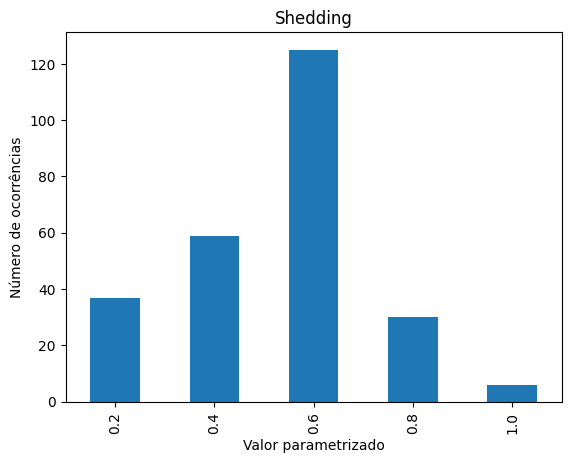

In [61]:
# Teste de organização de plotagem

shedding = dog_db['shedding_value']
count_shedding = shedding.value_counts().sort_index()

count_shedding.plot.bar(x=count_shedding.index)
plt.title("Shedding")
plt.xlabel("Valor parametrizado")
plt.ylabel("Número de ocorrências")
plt.show()

In [62]:
#Definição do atributo de saída

output_name = 'race'
dog_db = dog_db.rename(columns={dog_db.columns[0]: output_name})
# print(dog_db.columns)

In [63]:
#Retirada de atributos incompletos e codificação inteira

dog_db.dropna(inplace=True)
# print("----------------------------------------------------------------")
# print(dog_db)

int_encoder = LabelEncoder()
dog_db['group_value'] = int_encoder.fit_transform(dog_db['group'])

#Prints de testes para codificação da coluna 'groups'
# print(dog_db.head())
groups_val = int_encoder.classes_
print(groups_val)
uni_val = dog_db['group_value'].unique()
print(uni_val)

#Print para descobrir o valor atribuído a cada classe da coluna 'groups'
# for uni_val, groups_val in zip(dog_db['group_value'], dog_db['group']):
#   print(f'uni_val: {uni_val}, groups_val: {groups_val}')

print('Herding Group = 0\nHound Group = 1\nNon-Sporting Group = 2\nSporting Group = 3\nTerrier Group = 4\nToy Group = 5\nWorking Group = 6')

group_col = 'group'
dog_db = dog_db.drop(group_col, axis=1)
# print(dog_db.head())

['Herding Group' 'Hound Group' 'Non-Sporting Group' 'Sporting Group'
 'Terrier Group' 'Toy Group' 'Working Group']
[5 1 4 6 2 3 0]
Herding Group = 0
Hound Group = 1
Non-Sporting Group = 2
Sporting Group = 3
Terrier Group = 4
Toy Group = 5
Working Group = 6


In [64]:
#Normalização dos atributos

# dog_db['min_weight'] = dog_db['min_weight'].round(2)
# dog_db['max_weight'] = dog_db['max_weight'].round(2)
# print(dog_db.head())

# print(dog_db)

#Teste para descobrir qual coluna possuíam dados tipo 'string' qua não podiam ser tranformadas em float automaticamente pela função normalização
# for col_test in col_normalize:
#   if dog_db[col_test].dtype == object:
#     print(f"Coluna {col_test} contém string")

dog_db['popularity'] = pd.to_numeric(dog_db['popularity'], errors='coerce')

col_normalize = ['popularity', 'min_height', 'max_height', 'min_weight', 'max_weight', 'min_expectancy', 'max_expectancy', 'group_value']
scaler = MinMaxScaler()
dog_db[col_normalize] = scaler.fit_transform(dog_db[col_normalize])


# print(dog_db.head())

In [65]:
#Duplicação direta do banco de dados

double_dog = pd.concat([dog_db, dog_db], ignore_index=True)
#Prints de teste do banco de dados duplicado
print("<------------------------------ Nova tabela ------------------------------>")
print(double_dog.head())
print("<------------------------------ Tamanho da tabela ------------------------------>")
print(double_dog.shape)

<------------------------------ Nova tabela ------------------------------>
               race  popularity  min_height  max_height  min_weight  \
0     Affenpinscher    0.769634        0.16        0.18    0.046667   
1      Afghan Hound    0.586387        0.80        0.80    0.333333   
2  Airedale Terrier    0.308901        0.72        0.64    0.333333   
3             Akita    0.240838        0.76        0.84    0.466667   
4  Alaskan Malamute    0.298429        0.72        0.72    0.500000   

   max_weight  min_expectancy  max_expectancy  grooming_frequency_value  \
0    0.043478        0.800000        0.789474                       0.6   
1    0.260870        0.800000        0.789474                       0.8   
2    0.304348        0.733333        0.736842                       0.6   
3    0.565217        0.666667        0.684211                       0.8   
4    0.369565        0.666667        0.736842                       0.6   

   shedding_value  energy_level_value  trainab

<ipython-input-66-18ff2998825d>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = double_dog.corr()


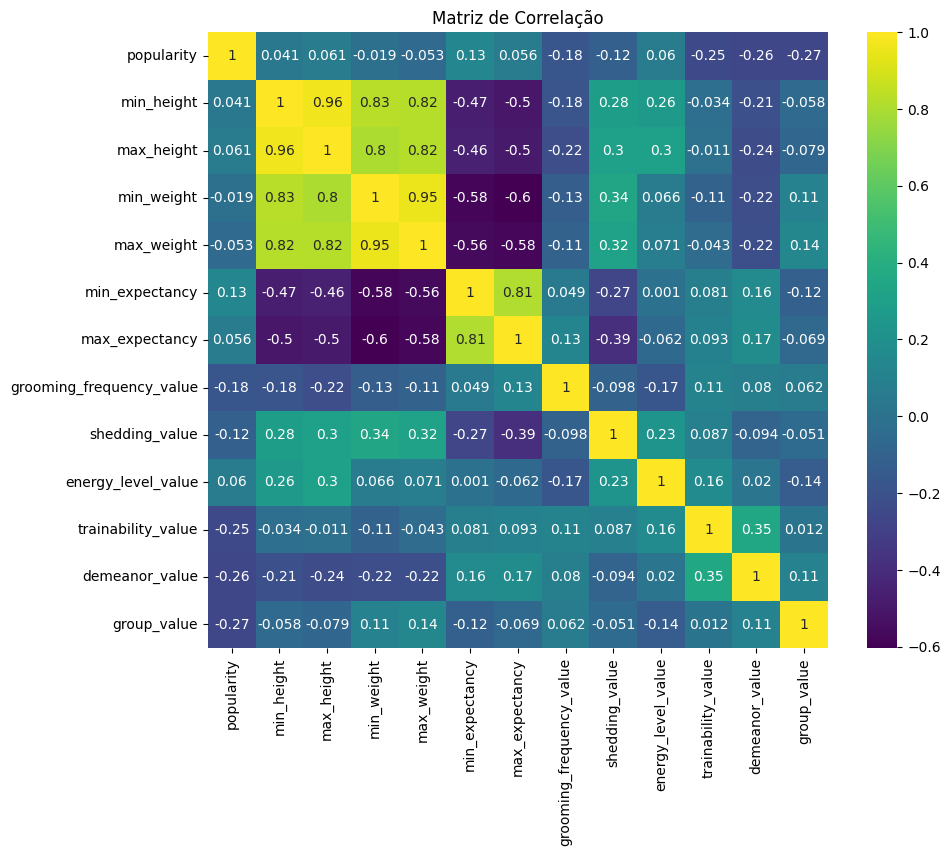

In [66]:
#Plotagem de gráficos relevantes

correlation_matrix = double_dog.corr()

plt.figure(figsize=(10,8))
sb.heatmap(correlation_matrix, annot=True, cmap='viridis')
plt.title('Matriz de Correlação')
plt.show()

In [67]:
#Implementação da Árvore de Decisão

# Definição dos atributos de entrada e saída
output = double_dog['race']
input = double_dog.drop('race', axis=1)
# print(output)
# print(input)

out_train, out_test, in_train, in_test = train_test_split(output, input, test_size=0.25, random_state=26)